# Tutorial on Coverage Maps

In this notebook, you will learn how to

- Compute and configure coverage maps
- Visualize different coverage map metrics, such as path gain, received signal
  strength (RSS), and signal-to-interference-plus-noise ratio (SINR)
- Interpret coverage map-based user-to-transmitter association
- Understand the effects of various precoding vectors on network coverage
- Sample user positions from a coverage map according to various criteria
- Generate channel impulse responses for sampled user positions

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Understanding coverage maps](#Understanding-coverage-maps)
    * [Metrics](#Metrics)
    * [Multiple transmitters](#Multiple-transmitters)
    * [User association](#User-association)
    * [Random sampling of user positions](#Sampling-of-random-user-positions)
    * [Directional antennas and precoding vectors](#Directional-antennas-and-precoding-vectors)
* [Coverage map for a realistic scene](#Coverage-map-for-a-realistic-scene)
* [Conclusions](#Conclusions)

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

# Other imports          
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import sys
    
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, watt_to_dbm
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft

## Understanding coverage maps

A [coverage map](https://nvlabs.github.io/sionna/api/rt.html#coverage-maps)
assigns a metric, such as path gain, received signal strength (RSS), or
signal-to-interference-plus-noise ratio (SINR), for a specific transmitter to
every point on a plane. In other words, for a given transmitter, it associates
every point on a surface with the channel gain, RSS, or SINR, that a receiver
with a specific orientation would observe at this point. 

A coverage map depends on the transmit and receive arrays and their respective
antenna patterns, the transmitter and receiver orientations, as well as the
transmit precoding and receive combining vectors. Moreover, a coverage map is
not continuous but discrete, as the plane must be quantized into small
rectangular bins, which we refer to as *cells*.

As a first example, we load an empty scene, place a single transmitter in it,
and compute a coverage map.

In [2]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,  # relative to wavelength
                             horizontal_spacing=0.5,  # relative to wavelength
                             pattern="iso",
                             polarization="V")
scene.rx_array = scene.tx_array

# Define and add a first transmitter to the scene
tx0 = Transmitter(name='tx0',
                  position=[150, -100, 20],
                  orientation=[np.pi*5/6, 0, 0],
                  power_dbm=44)
scene.add(tx0)

# Compute coverage map
cm = scene.coverage_map(max_depth=5,           # Maximum number of ray scene interactions
                        num_samples=int(10e6), # If you increase: less noise, but more memory required
                        cm_cell_size=(5, 5),   # Resolution of the coverage map
                        cm_center=[0, 0, 0],   # Center of the coverage map
                        cm_size=[400, 400],    # Total size of the coverage map
                        cm_orientation=[0, 0, 0]) # Orientation of the coverage map, e.g., could be also vertical

### Metrics

There are several ways to visualize a coverage map. The simplest option is to call the class method
[show()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.CoverageMap.show)
for the desired metric.

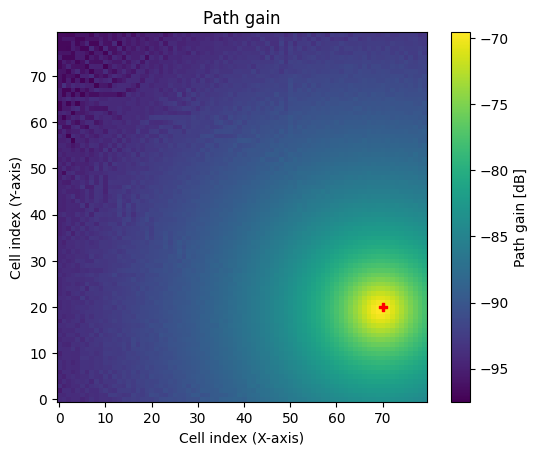

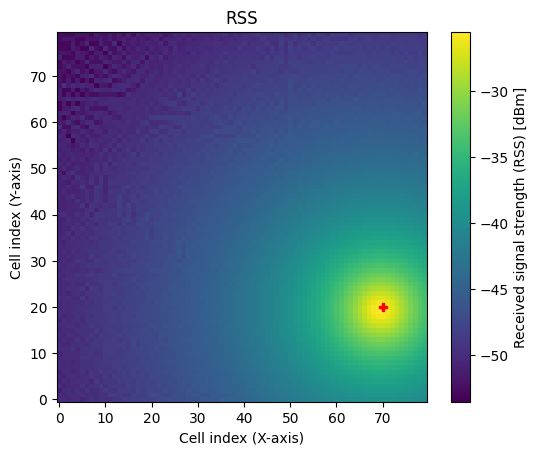

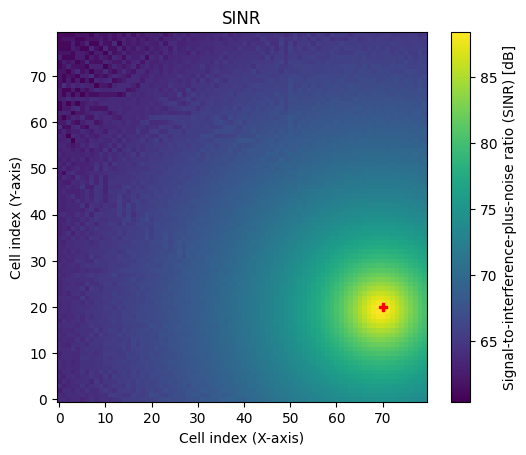

In [3]:
# Visualize path gain
cm.show(metric="path_gain");

# Visualize received signal strength (RSS)
cm.show(metric="rss");

# Visulaize SINR
cm.show(metric="sinr");

The RSS depends on the transmit power which can be modified for each
transmitter as shown below.

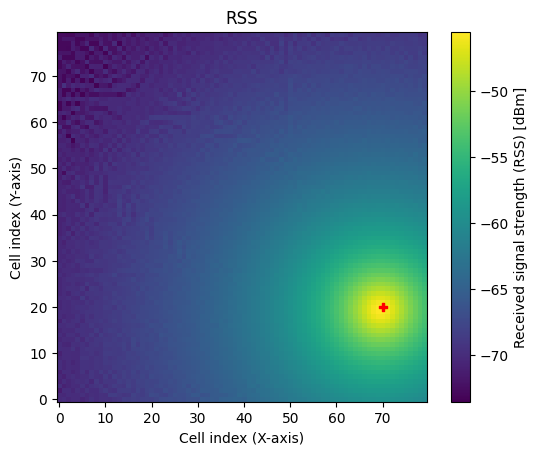

In [4]:
tx0.power_dbm = 24
cm.show(metric="rss");

Compared to the previous cell, the RSS is now 20dB smaller.

The SINR depends not only on the RSS from other transmitters in the scene but
also on the thermal noise power. The noise power is configured indirectly via the scene
properties [bandwidth](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Scene.bandwidth) and [temperature](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Scene.temperature). 

Note that neither parameter affects the ray tracing process; they are only used for the computation of the noise power.

In [5]:
print(f"Bandwidth: ", scene.bandwidth.numpy(), "[Hz]")
print(f"Temperature: ", scene.temperature.numpy(), "[K]")
print(f"Thermal noise power: ", watt_to_dbm(scene.thermal_noise_power).numpy(), "[dBm]")

Bandwidth:  1000000.0 [Hz]
Temperature:  293.0 [K]
Thermal noise power:  -113.9305 [dBm]


All metrics of a coverage map can be directly accessed as tensors as shown in
the next cell. This can be useful to define new metrics or visualize metrics in
a different form, such as CDF plots, etc.

In [6]:
# Metrics have the shape
# [num_tx, num_cells_y, num_cells_x]

print(f'{cm.path_gain.shape=}') # Path gain
print(f'{cm.rss.shape=}') # RSS
print(f'{cm.sinr.shape=}') # SINR

# The location of all cell centers in the global coordinate system of the scene 
# can be accessed via:
# [num_cells_y, num_cells_x, 3]
print(f'{cm.cell_centers.shape=}')

cm.path_gain.shape=TensorShape([1, 80, 80])
cm.rss.shape=TensorShape([1, 80, 80])
cm.sinr.shape=TensorShape([1, 80, 80])
cm.cell_centers.shape=TensorShape([80, 80, 3])


### Multiple transmitters

To make things more interesting, let us add two more transmitters
to the scene and recompute the coverage map.

In [7]:
# Remove transmitters here so that the cell can be executed multiple times
scene.remove("tx1")
scene.remove("tx2")

tx1 = Transmitter(name='tx1',
                  position=[-150, -100, 20],
                  orientation=[np.pi/6, 0, 0],
                  power_dbm=21)
scene.add(tx1)

tx2 = Transmitter(name='tx2',
                  position=[0, 150 * np.tan(np.pi/3) - 100, 20],
                  orientation=[-np.pi/2, 0, 0],
                  power_dbm=27)
scene.add(tx2)

cm = scene.coverage_map(max_depth=5,
                        num_samples=int(10e6),
                        cm_cell_size=(5, 5),
                        cm_center=[0, 0, 0],
                        cm_size=[400, 400],
                        cm_orientation=[0, 0, 0])

As soon as there are multiple transmitters in a scene, we can either visualize
a metric for specific transmitter or visualize the maximum matric across all
transmitters. The latter option is relevant if we want to inspect, e.g., the SINR across a large
scene, assuming that a receiver always connects to the transmitter providing
the best SINR.

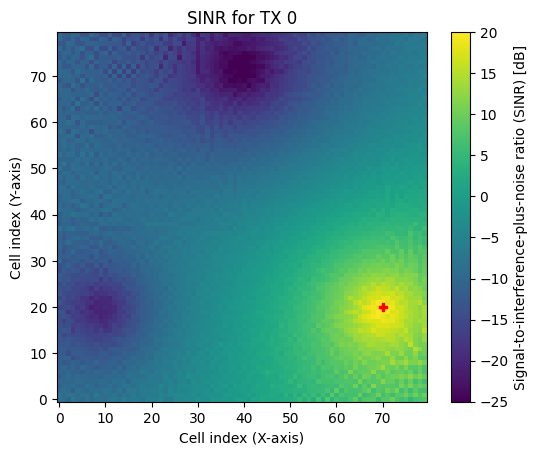

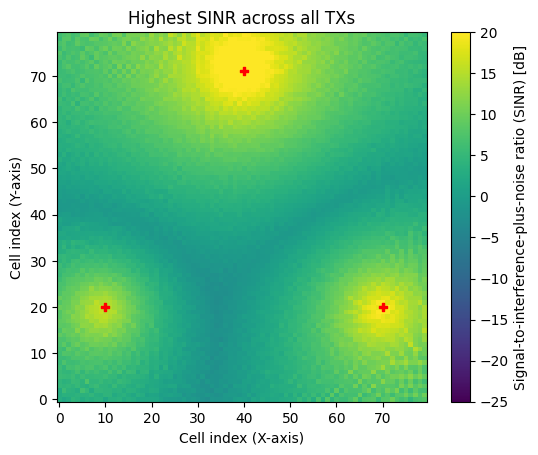

In [8]:
# Show SINR for tx0
cm.show(metric="sinr", tx=0, vmin=-25, vmax=20);

# Show maximum SINR across all transmitters
cm.show(metric="sinr", tx=None, vmin=-25, vmax=20);

# Experiment: Change the metric to "path_gain" or "rss"
#             and play around with the parameters vmin/vmax
#             that determine the range of the colormap

We can also visualize the cumulative distribution function (CDF) of the metric of interest:

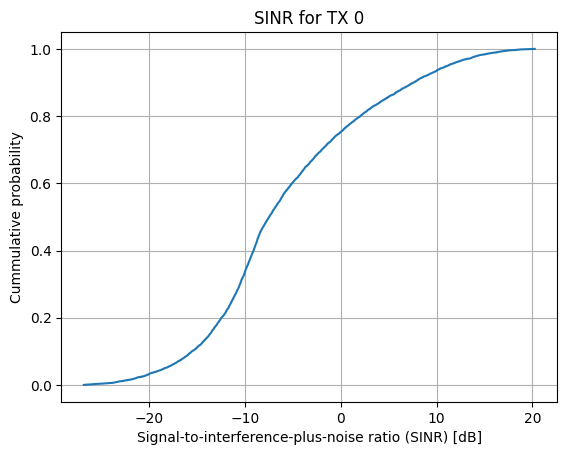

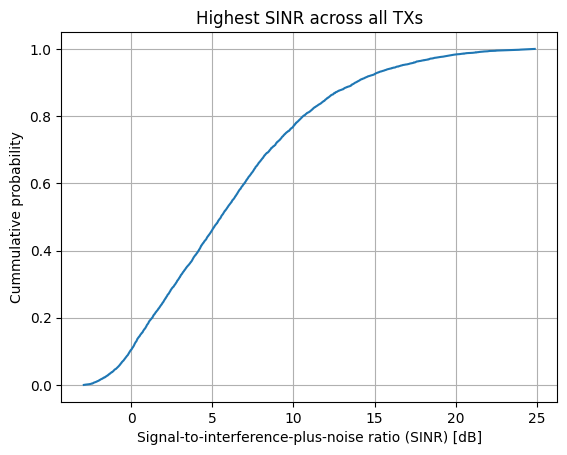

In [9]:
# CDF of the SINR for transmitter 0
cm.cdf(metric="sinr", tx=0);

# CDF of the SINR if always the transmitter providing the best SINR is selected
cm.cdf(metric="sinr");

Note that, at every position, the highest SINR across *all* transmitters is
always more favorable than the SINR offered by a *specific* transmitter (in math terms, the
former *stochastically dominates* the latter). This is clearly reflected in the
shape of the two distributions.

### User association

It is also interesting to investigate which regions of a coverage map are "covered" by each transmitter, i.e., where a transmitter provides the strongest metric. 
You can obtain this information either as a tensor from the class method [cell_to_tx()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Scene.cell_to_tx) or visualize it using [show_association()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Scene.show_association).

cm.cell_to_tx("sinr").shape=TensorShape([80, 80])


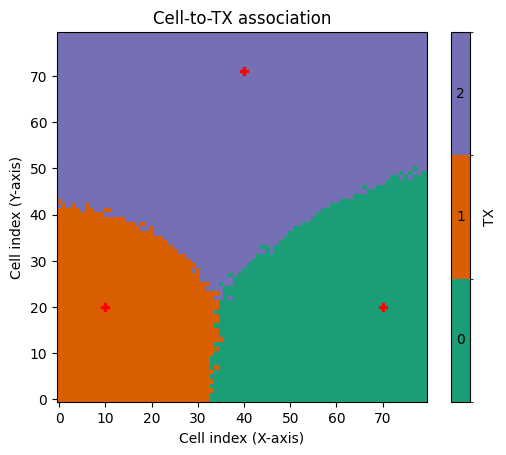

In [10]:
# Get for every cell the tx index providing the strongest value
# of the chosen metric
# [num_cells_y, num_cells_x]
print(f'{cm.cell_to_tx("sinr").shape=}')

cm.show_association("sinr");

### Sampling of random user positions

In some cases, one may want to drop receivers at random positions in a scene
while ensuring that the chosen positions have sufficient signal quality
(e.g., SINR)
and/or or are located within a certain range of a transmitter. The class
method [sample_positions()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Scene.sample_positions) is designed for this purpose, and you will see in the next
cell how it can be used.

You are encouraged to understand why the two different criteria used for sampling lead to the observed results. 

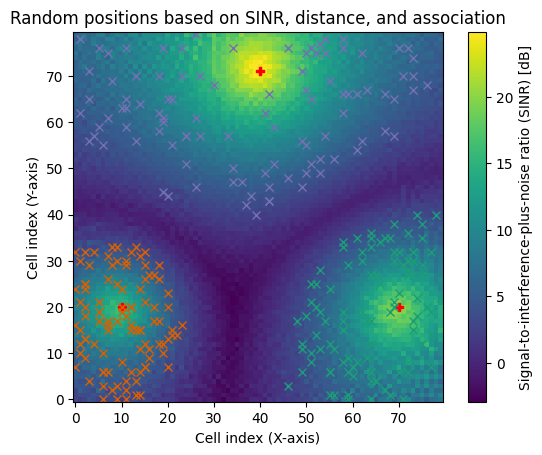

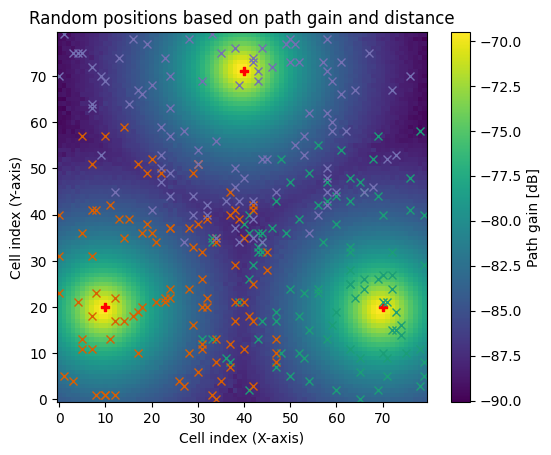

In [11]:
pos, cell_ids = cm.sample_positions(
          num_pos=100,         # Number of random positions per receiver
          metric="sinr",       # Metric on which constraints and TX association will be applied
          min_val_db=3,        # Mininum value for the chosen metric
          max_val_db=20,       # Maximum value for the chosen metric
          min_dist=10,         # Minimum distance from transmitter
          max_dist=200,        # Maximum distance from transmitter
          tx_association=True, # If True, only positions associated with a transmitter are chosen,
                               # i.e., positions where the chosen metric is the highest among all TXs
          center_pos=False)    # If True, random positions correspond to cell centers,
                               # otherwise a random offset within each cell is applied

fig = cm.show(metric="sinr");
plt.title("Random positions based on SINR, distance, and association")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids):
    fig.axes[0].plot(ids[:,0], ids[:,1],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])


pos, cell_ids = cm.sample_positions(
          num_pos=100,          # Number of random positions per receiver
          metric="path_gain",   # Metric on which constraints will be applied
          min_dist=10,          # Minimum distance from transmitter
          max_dist=200,         # Maximum distance from transmitter
          tx_association=False, # If False, then a user located in a sampled position 
                                # for a specific TX may perceive a higher metric from another TX!
          center_pos=False)     # If True, random positions correspond to cell centers,
                                # otherwise a random offset within each cell is applied

fig = cm.show(metric="path_gain");
plt.title("Random positions based on path gain and distance")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids):
    fig.axes[0].plot(ids[:,0], ids[:,1],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

### Directional antennas and precoding vectors

As mentioned above, coverage maps heavily depend on the chosen antenna patterns and precoding vectors.
In the next cell, we will study how their impact on a coverage map via several visualizations. 

Let us start by assigning a single antenna to all transmitters and computing the
corresponding coverage map:

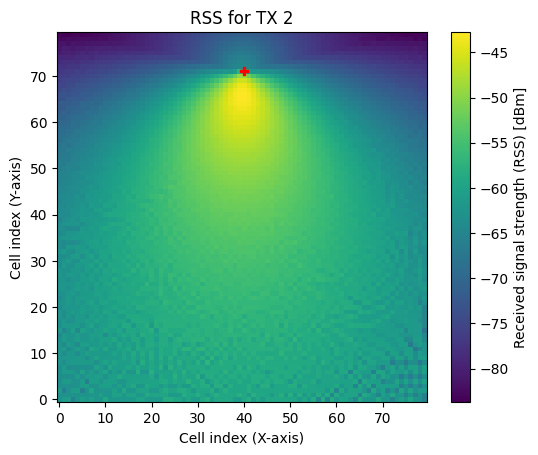

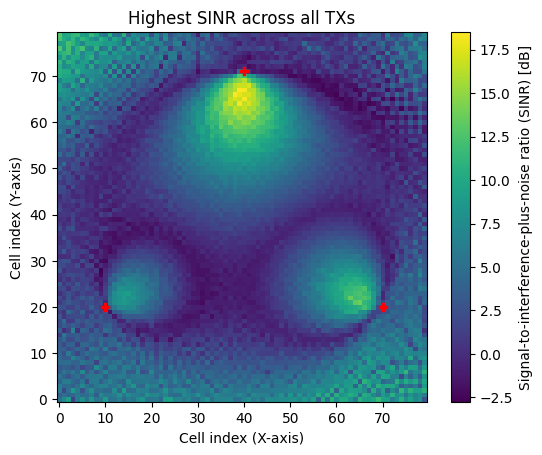

In [12]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",   # Change to "iso" and compare the results
                             polarization="V")

cm = scene.coverage_map(max_depth=5,
                        num_samples=int(10e6),
                        cm_cell_size=(5, 5),
                        cm_center=[0, 0, 0],
                        cm_size=[400, 400],
                        cm_orientation=[0, 0, 0])

cm.show(metric="rss", tx=2);
# plt.suptitle("RSS for TX 2")

cm.show(metric="sinr");
# plt.suptitle("SINR for best TX")

We now add more antennas to the antenna array of the transmitters and apply a
precoding vector chosen from a Discrete Fourier Transform (DFT) beam grid.

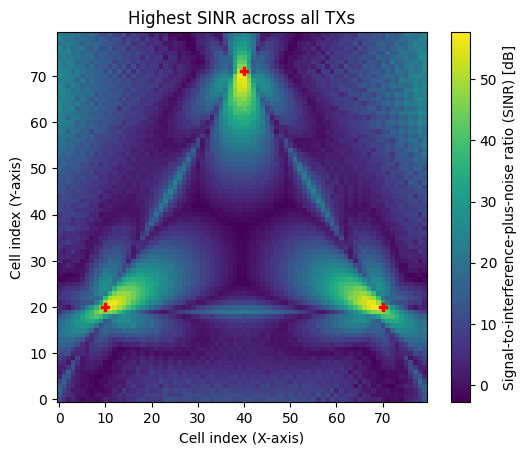

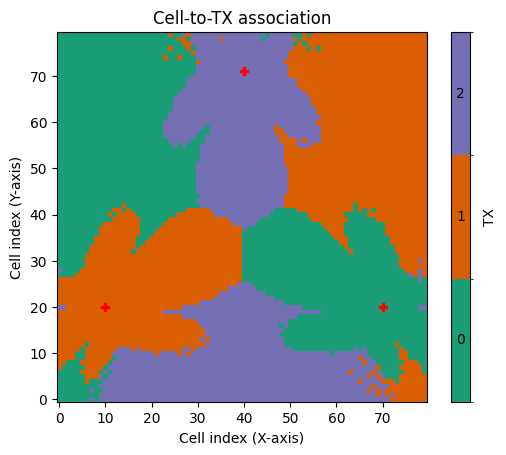

In [13]:
# Number of elements of the rectangular antenna array
num_rows = 2
num_cols = 4

# Configure all transmitters to have equal power
tx0.power_dbm = 23
tx1.power_dbm = 23
tx2.power_dbm = 23

# Configure tr38901 uniform rectangular antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=num_rows,
                             num_cols=num_cols,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# compute a Grid of Beams (GoB) of Discrete Fourier Transform (DFT) beams
gob = grid_of_beams_dft(num_rows, num_cols)

# select a precoding beams for each transmitter
# choose beam row within [0, .., num_rows-1]
# choose beam column within [0, .., num_cols-1]
precoding_vec = tf.stack([gob[1,0],
                          gob[1,0],
                          gob[1,0]], axis=0)

# normalize to unitary power (although not needed for DFT beams)
precoding_vec = normalize_precoding_power(precoding_vec)

# Compute the SINR map
cm = scene.coverage_map(
        max_depth=5,
        diffraction=True,  # Disable to see the effects of diffraction
        cm_cell_size=(5, 5),  # size of each tile
        precoding_vec=precoding_vec,
        num_samples=int(10e6),  # Decrease to reduce memory consumption
        cm_center=[0, 0, 0],
        cm_size=[400, 400],
        cm_orientation=[0, 0, 0])

cm.show(metric="sinr");
cm.show_association(metric="sinr");


The use of antenna arrays and precoding vectors leads to complicated, even
artistic looking, coverage maps with sometimes counter-intuitive regions of user
association. Nevertheless, we can still sample user positions for each transmitter.

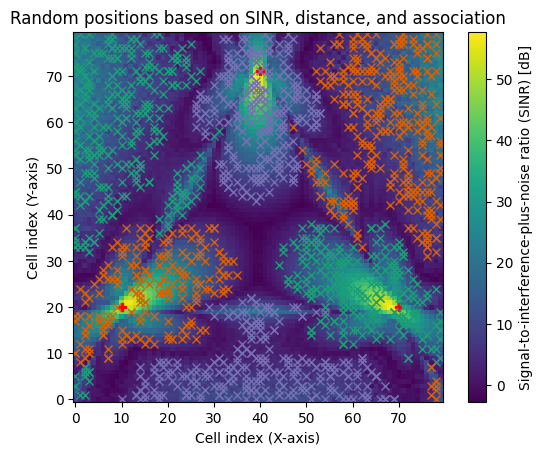

In [14]:
pos, cell_ids = cm.sample_positions(
          num_pos=500,         
          metric="sinr",       
          min_val_db=3,        
          min_dist=10,         
          tx_association=True)

fig = cm.show(metric="sinr");
# Visualize sampled positions
for tx, ids in enumerate(cell_ids):
    fig.axes[0].plot(ids[:,0], ids[:,1],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])
plt.title("Random positions based on SINR, distance, and association");

Exercise: Unleash your inner artist by changing the number of rows/columns of the antenna array and
assigning different DFT precoding vectors to every transmitter to assess their impact on the
maps!

## Coverage map for a realistic scene

Until now, we have only looked at coverage maps in an empty scene. Let's spice things up a little bit
and load a more interesting scene, place transmitters, and inspect the resulting coverage map.

In [15]:
def config_scene(num_rows, num_cols):
    scene = load_scene(sionna.rt.scene.etoile)
    scene.add(Camera("cam",
                     position=[0,0,1000],
                     orientation=[0,np.pi/2,-np.pi/2]))
    scene.bandwidth=100e6
    
    # Configure antenna arrays for all transmitters and receivers
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="tr38901",
                                 polarization="V")
    
    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")

    # Place transmitters
    positions = [[-150.3, 21.63, 42.5],
                 [-125.1, 9.58, 42.5],
                 [-104.5, 54.94, 42.5],
                 [-128.6, 66.73, 42.5],
                 [172.1, 103.7, 24],
                 [232.8, -95.5, 17],
                 [80.1, 193.8, 21]
                ]
    look_ats = [[-216, -21,0],
                [-90, -80, 0],
                [-16.5, 75.8, 0],
                [-164, 153.7, 0],
                [247, 92, 0],
                [211, -180, 0],
                [126.3, 194.7, 0]
               ]
    power_dbms = [23, 23, 23, 23, 23, 23, 23]

    for i, position in enumerate(positions):
        scene.add(Transmitter(name=f'tx{i}',
                              position=position,
                              look_at=look_ats[i],
                              power_dbm=power_dbms[i]))

    return scene  

In [16]:
# Load and configure scene
num_rows=8
num_cols=2
scene_etoile = config_scene(num_rows, num_cols)

# Compute the SINR map
cm_etoile = scene_etoile.coverage_map(
    max_depth=7,
    los=True,
    reflection=True,
    diffraction=True,
    cm_cell_size=(1, 1),
    num_samples=int(10e6),  # Decrease to reduce memory consumption
    num_runs=1)  # Increase to average over multiple coverage maps to reduce noise

To get a global view of the coverage, let us visualize the coverage map in the preview (or  rendered image). These are alternatives to the [show()](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Scene.show) method we have used until now, which also visualizes the objects in a scene.

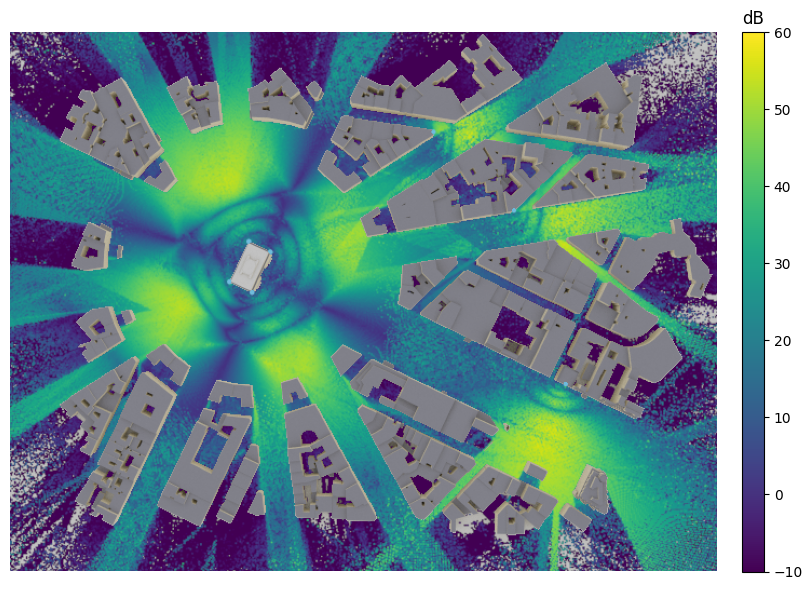

In [17]:
%%skip_if not no_preview

# Render an image if run in Colab
plt.ioff()
scene_etoile.render(camera="cam",
                    coverage_map=cm_etoile,
                    cm_metric="sinr",
                    cm_vmin=-10,
                    cm_vmax=60,
                    num_samples=512);

In [18]:
%%skip_if no_preview
# Show coverage map in preview
scene_etoile.preview(coverage_map=cm_etoile,
                     cm_metric="sinr",
                     cm_vmin=-10,)

### Channel impulse responses for random user locations

With a coverage map at hand, we can now sample random positions at which we place actual receivers and then compute channel impulse responses.

In [19]:
cm_etoile.show_association("sinr");

pos, cell_ids = cm_etoile.sample_positions(
          num_pos=4,         
          metric="sinr",       
          min_val_db=3,        
          min_dist=10,
          max_dist=200,
          tx_association=True)

fig = cm_etoile.show(metric="sinr", vmin=-10);

# Visualize sampled positions
for tx, ids in enumerate(cell_ids):
    fig.axes[0].plot(ids[:,0], ids[:,1],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

In [20]:
[scene_etoile.remove(rx.name) for rx in scene_etoile.receivers.values()]
for i in range(cm_etoile.num_tx):
    for j in range(pos.shape[1]):
        scene_etoile.add(Receiver(name=f"rx-{i}-{j}",
                           position=pos[i,j]))

paths = scene_etoile.compute_paths(max_depth=3)

# Channel impulse response
a, tau = paths.cir()

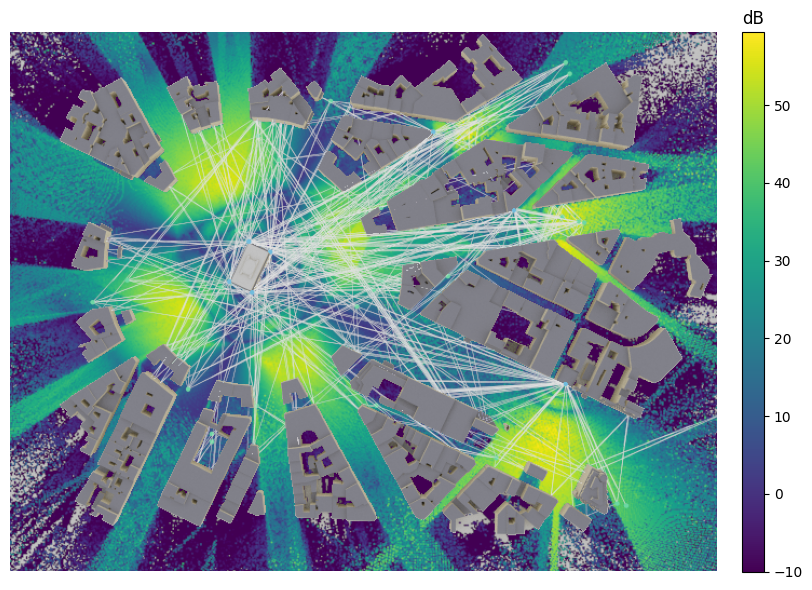

In [21]:
%%skip_if not no_preview
# Render an image if run in Colab
plt.ioff()
scene_etoile.render(camera="cam",
                    paths=paths,
                    coverage_map=cm_etoile,
                    cm_metric="sinr",
                    cm_vmin=-10,
                    num_samples=512);

In [22]:
%%skip_if no_preview
# Show coverage map in preview
scene_etoile.preview(paths=paths,
                     coverage_map=cm_etoile,
                     cm_metric="sinr",
                     cm_vmin=-10)

## Conclusions

Coverage maps are a highly versatile feature of Sionna. They are particularly
useful for defining meaningful areas for random user drops that meet certain
coverage constraints, or for investigating the placement and
configuration of transmitters in a scene.

However, we have barely scratched the surface of their potential. For example,
observe that the metrics of a coverage map are differentiable with respect to most
scene parameters, such as transmitter orientations, transmit power, antenna
patterns, precoding vectors, and RIS spatial modulation coefficients. This
opens up a wide range of possibilities for gradient-based optimization.

We hope you found this tutorial on coverage maps in Sionna RT informative. We
encourage you to get your hands on it, conduct your own experiments and deepen your understanding
of ray tracing. There's always more to learn, so be sure to explore our other
[tutorials](https://nvlabs.github.io/sionna/tutorials.html) as well!